# Fake News Detction Model
* Author: Ji Hoon Chung

![Fakenews](Images/Fakenews.jpeg)

## Business Problem

We are living in an unprecedented era where we are easily being exposed to tons of news on social media which we did not intend to spot. From premature juveniles to mature adults with higher degrees of education, fake news could easily deprive their factual senses and having them fallen down to imperfect beliefs. <br>

Accordingly, it is crucial for social media platforms to detect fake news automatically to prohibit their exposure in the first place.<br>

Our clients are Social Media Platforms like Facebook, Twitter, and LinkedIn. I would like to introduce a machine learning model being able to classify fake news aside from actual news using the words and patterns that are prevalent in conventional news dataset.

To define Fake News, 
<b>"fake news is a type of yellow journalism or propaganda that consists of deliberate misinformation or hoaxes spread via traditional print and broadcast news media or online social media</b>
<br>
Source = https://library.gannon.edu/c.php?g=728528&p=5206339

We'll be dealing with Natural Language Processing technique to fully dive into bulding our classification model.
<br><br>
The Python programing language provides a wide range of tools and libraries for attacking specific NLP tasks. Many of these are found in the Natural Language Toolkit, or NLTK, an open source collection of libraries, programs, and education resources for building NLP programs.
<br><br>
The NLTK includes libraries for many of the NLP tasks listed above, plus libraries for subtasks, such as sentence parsing, word segmentation, stemming and lemmatization (methods of trimming words down to their roots), and tokenization (for breaking phrases, sentences, paragraphs and passages into tokens that help the computer better understand the text). It also includes libraries for implementing capabilities such as semantic reasoning, the ability to reach logical conclusions based on facts extracted from text.
<br><br>
Source = https://www.ibm.com/cloud/learn/natural-language-processing

## Overview

Dataset is obtained from source: https://drive.google.com/file/d/1er9NJTLUA3qnRuyhfzuN0XUsoIC4a-_q/view <br>

I’ve collected a dataset which includes 6,335 rows of data containing 3,171 real news vs 3,164 fake news. Dataset will be resampled with 0.17:1.0 FAKE to REAL news ratio. (Real World Fake to Real news ratio). Dataset is very straight forward containing only 3 columns such as, title, text (article contents), and label indicating real or fake.<br>

Text Dataset will be broken into 3 categories for further investigation:
1. Original Text Data
2. Lemmatized Text Data
3. Stemmed Text Data

Text dataset will be trained after they are transformed into either one of the two vectorizers:
1. TFIDFVectorizer.
2. CounterVectorizer.
<br><br>
These vectorizers will convert text into form of matrices and we'll be able to perform classification model training.

For the evaluation, both the precision & recall score would be important, but I would weigh more in the precision score as true positive rate should maintain high enough to have credibility in our model's FAKE news detection accuracy. For the Cross Valdiation, we will evaluate metric for the F1 score as balance begtween precision & recall is still very important.

# 1. Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import string
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve, auc, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from wordcloud import WordCloud,STOPWORDS
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import inaugural, wordnet, stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import WhitespaceTokenizer as w_tokenizer
from nltk.tag import pos_tag
from collections import Counter
from itertools import chain, filterfalse as ifilterfalse
from scipy import stats
import statsmodels
from statsmodels.formula.api import ols
warnings.filterwarnings('ignore')

## 1.1 Load & Clean Up Data

In [2]:
# Import Dataset
df = pd.read_csv("./data/news 2.csv")

In [3]:
# Dataset Overview
df.sample(10)

,Unnamed: 0,title,text,label
3860,2550,Trump: Undocumented Children Aren't US Citizens,Billionare Donald Trump is doubling down on hi...,REAL
3467,6738,Even Doctors Are Surprised: This Recipe Renews...,Share on Facebook Experts claim that the impro...,FAKE
5146,7767,DISGUSTING Evolution Of Political Correctness ...,You are here: Home / US / DISGUSTING Evolution...,FAKE
5263,7235,French Jews urged to rally over UNESCO resolut...,"October 28, 2016 French Jews urged to rally ov...",FAKE
3820,8818,GOVERNMENT HIDING UNPRECEDENTED TB INFECTION R...,Home › HEALTH › GOVERNMENT HIDING UNPRECEDENTE...,FAKE
1731,9153,Why Everyone on Facebook Is Checking into Stan...,Pin 1 \n( ANTIMEDIA ) When it comes to brute f...,FAKE
1037,10457,Reasons to Risk Nuclear Annihilation,Reasons to Risk Nuclear Annihilation latest ...,FAKE
5191,9015,"Clinton, FBIGate and the true depth of the Oba...","Clinton, FBIGate and the true depth of the Oba...",FAKE
4002,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,REAL
302,9196,Re: WikiLeaks: Neera Tanden has ANOTHER ringin...,WikiLeaks: Neera Tanden has ANOTHER ringing en...,FAKE


It seems like most of the news are political within political category.

In [4]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

Null value does not exist within the dataset.

In [5]:
# Combine Title into text and drop title from the dataframe.
df['text'] = df['title'] + df['text']
df.drop('title', inplace=True, axis=1)

In [6]:
# Text and Title are combined.
df.head()

,Unnamed: 0,text,label
0,8476,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathyU.S...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,FAKE
4,875,The Battle of New York: Why This Primary Matte...,REAL


In [7]:
# Drop unnecessary columns.
df = df.drop(['Unnamed: 0'], axis=1)

## 1.2 Lemmatization & Stemming

For more detailed investigation on the text, I will prepare lemmatized & stemmed text dataset to see if these will bring better accuracy on our classification model later on.<br>

1. In lemmatization, the part of speech of a word should be first determined and the normalisation rules will be different for different part of speech, while the stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. <br>
<br>
2. A stemmer will return the stem of a word, which needn't be identical to the morphological root of the word. It usually sufficient that related words map to the same stem,even if the stem is not in itself a valid root, while in lemmatisation, it will return the dictionary form of a word, which must be a valid word.
<br><br>
Source: https://stackoverflow.com/questions/1787110/what-is-the-difference-between-lemmatization-vs-stemming

### 1.2.1 Lemmatization

In [8]:
# Lemmatzie Fundtion after POS-TAG
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word

In [9]:
# Joining Lemmatized Text with a space.
def join_lemmatize(lem):
    return ' '.join(lem)

In [10]:
# Get the tokens lemmatized.
df['lemmatized_text'] = df['text'].apply((lemmatize_all))

In [11]:
# Construct lemmatized dataset.
df['lemmatized_text'] = df['lemmatized_text'].apply((join_lemmatize))

In [12]:
df.head()

,text,label,lemmatized_text
0,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE,You Can Smell Hillary ’ s FearDaniel Greenfiel...
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
2,Kerry to go to Paris in gesture of sympathyU.S...,REAL,Kerry to go to Paris in gesture of sympathyU.S...
3,Bernie supporters on Twitter erupt in anger ag...,FAKE,Bernie supporter on Twitter erupt in anger aga...
4,The Battle of New York: Why This Primary Matte...,REAL,The Battle of New York : Why This Primary Matt...


### 1.2.2 Stemming

In [13]:
# Construct Tokenize Dataset
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
df['tokenized_sents'] = df.apply(lambda row: w_tokenizer.tokenize(row['text']), axis=1)

In [14]:
# Stemmer Function
def stemmer_text(text):
    ps = PorterStemmer()
    return [ps.stem(w) for w in text] 

In [15]:
# Consturct Stemmed dataset.
df['stemmer_text'] = df['tokenized_sents'].apply(stemmer_text)

In [16]:
def list_to_string(text):
    return ' '.join(str(e) for e in text)

In [17]:
# Convert List to String
df['stemmer_text'] = df['stemmer_text'].apply(list_to_string)

In [18]:
# Final Dataset for Model Building
df.head()

,text,label,lemmatized_text,tokenized_sents,stemmer_text
0,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE,You Can Smell Hillary ’ s FearDaniel Greenfiel...,"[You, Can, Smell, Hillary’s, FearDaniel, Green...","you can smell hillary’ feardaniel greenfield, ..."
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,"[Watch, The, Exact, Moment, Paul, Ryan, Commit...",watch the exact moment paul ryan commit polit ...
2,Kerry to go to Paris in gesture of sympathyU.S...,REAL,Kerry to go to Paris in gesture of sympathyU.S...,"[Kerry, to, go, to, Paris, in, gesture, of, sy...",kerri to go to pari in gestur of sympathyu.s. ...
3,Bernie supporters on Twitter erupt in anger ag...,FAKE,Bernie supporter on Twitter erupt in anger aga...,"[Bernie, supporters, on, Twitter, erupt, in, a...",berni support on twitter erupt in anger agains...
4,The Battle of New York: Why This Primary Matte...,REAL,The Battle of New York : Why This Primary Matt...,"[The, Battle, of, New, York:, Why, This, Prima...",the battl of new york: whi thi primari matters...


## 1.3 EDA

### 1.3.1 Text length comparison between FAKE vs. REAL News

In [19]:
df["words_used"] = np.nan

In [20]:
## See how may words are used per text
for i in range(len(df.text)-1):
    df['words_used'].iloc[i] = len(df['text'].iloc[i].split())

In [21]:
df_words = df.groupby('label').agg({'words_used':['mean', 'median', 'std', 'min', 'max']})

In [22]:
res = len(df['text'].iloc[1].split())

In [23]:
df_words.reset_index(inplace=True)

FAKE news articles contains less mean & median number of words whereas their standard deviation is a lot larger indicating they have more versatility in lengh of an article.

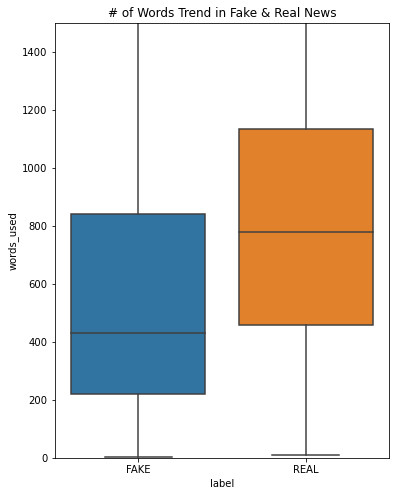

In [24]:
fig, ax = plt.subplots(figsize=(6,8))
ax = sns.boxplot(x='label', y='words_used', data=df)
ax.set_ylim(0,1500)
ax.set_title('# of Words Trend in Fake & Real News')
plt.savefig('./images/word_trend.png');

In [25]:
df.words_used.fillna(0, inplace=True)

In [26]:
# Conduct 2-Sample T-Test to see if we can reject null hypothesis.
stats.ttest_ind(df[df.label=='FAKE']['words_used'], df[df.label=='REAL']['words_used'])

Ttest_indResult(statistic=-9.021660039114863, pvalue=2.416269112428002e-19)

Overally, FAKE news has lower average length compared to REAL news. <br>
Since Two Sample T-Test shows significantly low p-value less than 0.05, we can reject the null hypothesis: <br>
<b>Number of words used is significantly related with the news article being FAKE or REAL.</b>

***

### 1.3.2 Word Cloud

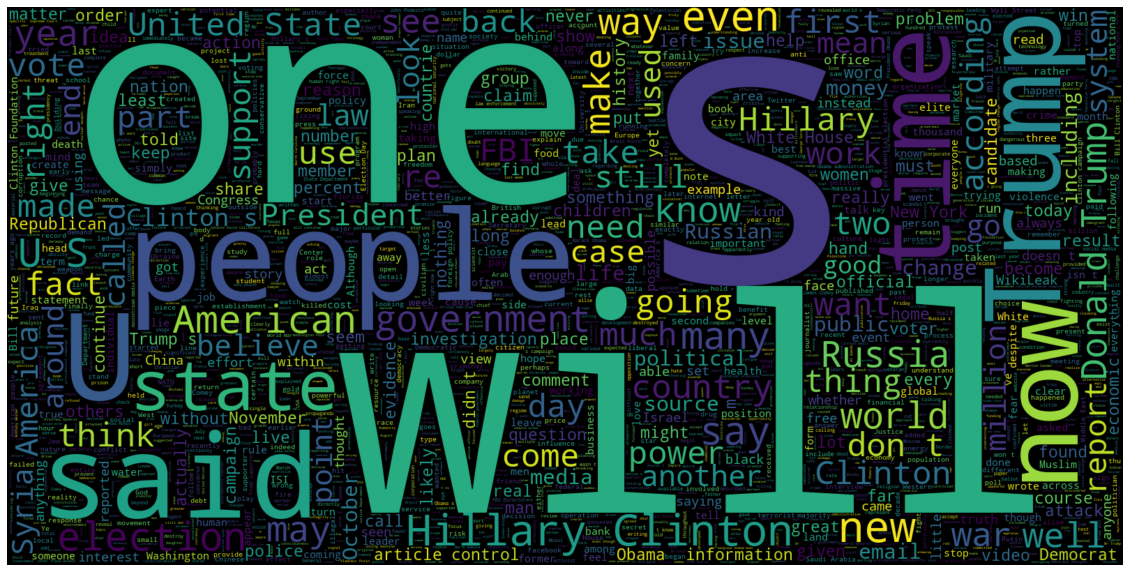

In [27]:
# Fake News Word Cloud
plt.figure(figsize = (20,20)) # Text from the real news articles
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.label == 'FAKE'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show
plt.savefig('./images/Fake_wordcloud.png');

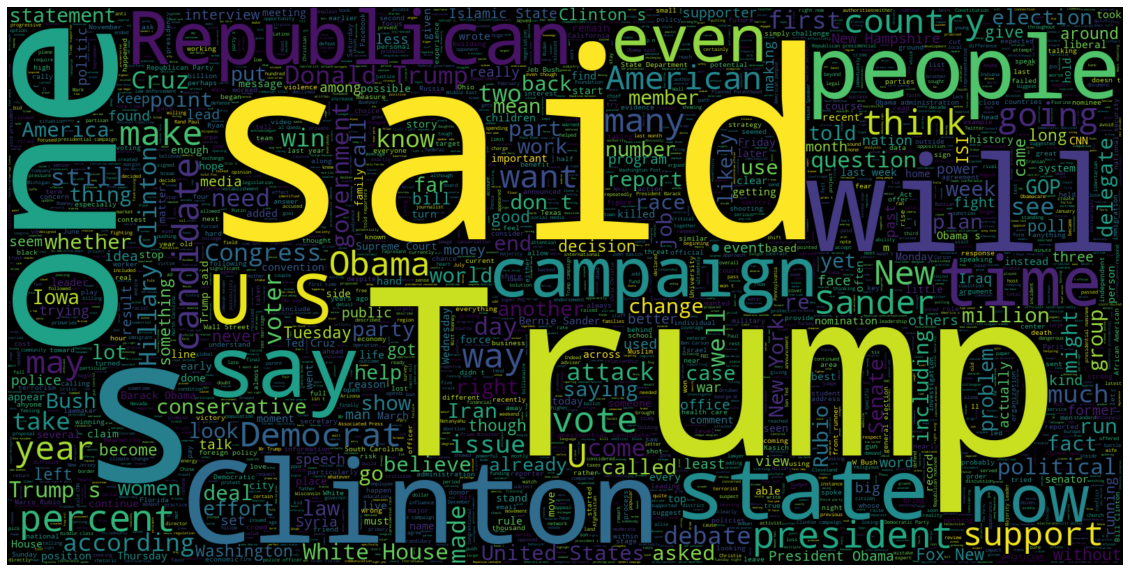

In [28]:
# Real News Word Cloud
plt.figure(figsize = (20,20)) # Text from the real news articles
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.label == 'REAL'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show
plt.savefig('./images/Real_wordcloud.png');

Looking at word Cloud, it's hard to tell the distinction between two types of articles. However, it is evident that both articles are mainly about the US politics.

***

### 1.3.3 Top 10 Word Frequency Distribution Comparison

Since Wordcloud does not bring too much insightful information, let's try comparing Top 10 Word counts per Article Type using barplot.

In [29]:
# Count Words Function with the stopwords excluded from the count
def countwords(text):
    stops = stopwords.words('english')
    words = chain.from_iterable(line.split() for line in text)
    return Counter(word for word in words if word not in stops)

In [30]:
# Get Real News Word Count Dataset, change all text into lowercase to enable stopwords
df_real = df[df.label=='REAL']
df_real = df_real.text.str.lower()

In [31]:
# Get FAKE News Word Count Dataset, change all text into lowercase to enable stopwords
df_fake = df[df.label=='FAKE']
df_fake = df_fake.text.str.lower()

In [32]:
# Set Real News Word Counts
wordcount_real = countwords(df_real)

In [33]:
# Set FAKE News Word Counts
wordcount_fake = countwords(df_fake)

In [34]:
# Get the Top 10 most common words
wordcount_real = wordcount_real.most_common(10)
wordcount_fake = wordcount_fake.most_common(10)

In [35]:
# Retrieve X and Y values of the words and word counts
x_real = []
y_real = []

for i in range (10):
    x_real.append(wordcount_real[i][0])
    y_real.append(wordcount_real[i][1])
    
x_fake = []
y_fake = []

for i in range (10):
    x_fake.append(wordcount_fake[i][0])
    y_fake.append(wordcount_fake[i][1])

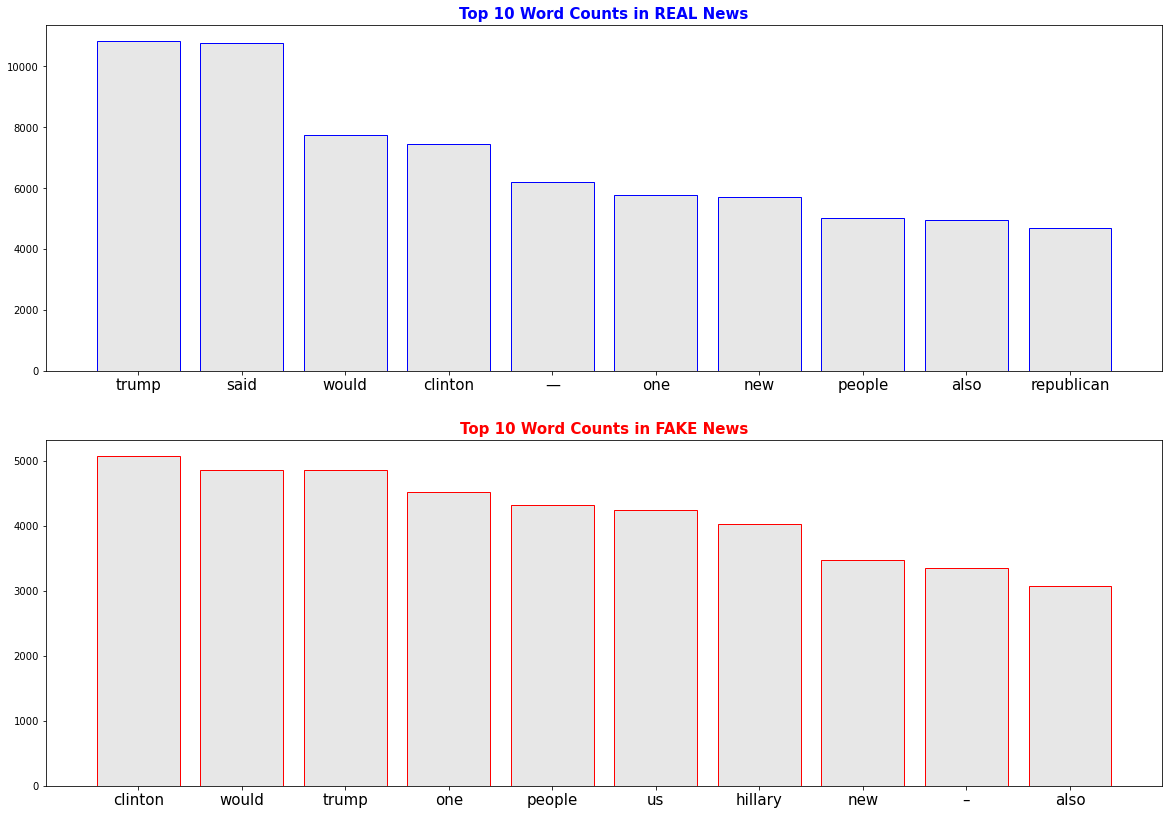

In [36]:
# Get the barplot of TOP 10 Word Counts for REAL & FAKE News.
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,14))

ax1.bar(x_real, y_real, color= (0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
ax2.bar(x_fake, y_fake, color= (0.1, 0.1, 0.1, 0.1),  edgecolor='red')

ax1.set_title('Top 10 Word Counts in REAL News', fontdict = {'fontsize':15, 'fontweight':'bold', 'color':'blue'})
ax2.set_title('Top 10 Word Counts in FAKE News', fontdict = {'fontsize':15, 'fontweight':'bold', 'color':'red'})

ax1.tick_params(axis='x', which='major', labelsize=15)
ax2.tick_params(axis='x', which='major', labelsize=15)

plt.savefig('./images/Top10_WordCounts.png');

According to the Plot, there are a few notable differences between REAL & FAKE NEWS:
1. Trump was much widely used in REAL news whereas Clinton was more widely used in FAKE News.
2. It looks like FAKE news was more susceptible in using Full Name of Hilary Clinton.
3. 'US' was very widely used in FAKE news wheareas it was not one of the TOP 10 words in REAL news.

***

# 2. General Modeling

## 2.1 Splitting Dataset for Modeling.

In [37]:
# Original Text X
X_text = df['text']

# Stemmed Text X
X_stem = df['stemmer_text']

#Lemmatized Text X
X_lem = df['lemmatized_text']

#Target Variable
y = df['label']

In [38]:
y = pd.DataFrame(np.where(y=='FAKE', 1, 0))

In [39]:
#DataFlair - Split the dataset (For Original Text)
x_text_train, x_text_test, y_text_train, y_text_test=train_test_split(X_text, y, test_size=0.2, random_state=7)

In [40]:
#DataFlair - Split the dataset (For Stemmed Text)
x_stem_train, x_stem_test, y_stem_train, y_stem_test=train_test_split(X_stem, y, test_size=0.2, random_state=7)

In [41]:
#DataFlair - Split the dataset (For Lemmatized Text)
x_lem_train, x_lem_test, y_lem_train, y_lem_test=train_test_split(X_lem, y, test_size=0.2, random_state=7)

## 2.2 Decision Tree Model (Without Adjusting Class Balance)

In [58]:
# Build a pipeline with TfIDFVectorizer and Decision Tree Classifer
tree_tf_pipeline = Pipeline([('vect',TfidfVectorizer()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search (for original text)
gs1_t = GridSearchCV(estimator=tree_tf_pipeline, 
                          param_grid=grid, 
                          scoring='f1_micro', 
                          cv=5)

In [52]:
# Build a pipeline with TfIDFVectorizer and Decision Tree Classifer
tree_tf_pipeline = Pipeline([('vect',TfidfVectorizer()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search (for stemmed text)
gs1_s = GridSearchCV(estimator=tree_tf_pipeline, 
                          param_grid=grid, 
                          scoring='f1_micro', 
                          cv=5)

In [53]:
# Build a pipeline with TfIDFVectorizer and Decision Tree Classifer
tree_tf_pipeline = Pipeline([('vect',TfidfVectorizer()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search (for lemmatized text)
gs1_l = GridSearchCV(estimator=tree_tf_pipeline, 
                          param_grid=grid, 
                          scoring='f1_micro', 
                          cv=5)

In [54]:
# Build a pipeline with CountVectorizer and Decision Tree Classifer
tree_ct_pipeline = Pipeline([('vect',CountVectorizer()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search (for original text)
gs2_t = GridSearchCV(estimator=tree_ct_pipeline, 
                          param_grid=grid, 
                          scoring='f1_micro', 
                          cv=5)

In [55]:
# Build a pipeline with CountVectorizer and Decision Tree Classifer
tree_ct_pipeline = Pipeline([('vect',CountVectorizer()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search (for stemmed text)
gs2_s = GridSearchCV(estimator=tree_ct_pipeline, 
                          param_grid=grid, 
                          scoring='f1_micro', 
                          cv=5)

In [56]:
# Build a pipeline with CountVectorizer and Decision Tree Classifer
tree_ct_pipeline = Pipeline([('vect',CountVectorizer()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search (for lemmatized text)
gs2_l = GridSearchCV(estimator=tree_ct_pipeline, 
                          param_grid=grid, 
                          scoring='f1_micro', 
                          cv=5)

### 2.2.1 TFIDF Vectorizer Cross Validation Results

For cross validation score, I will evaluate performance using the F1-Score assuming that balance between Precision and Recall should be high to bo build a successful model. It is crticial to maintain low False Postiive & False Negative Rate in balance.  <br>
<br>
1. Precision = What proportion of positive identifications was actually correct?
2. Recall = What proportion of actual positives was identified correctly?



In [59]:
# Using Original Text Dataset
gs1_t.fit(x_text_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

Best F1_Score: 0.821


In [66]:
gs1_t.best_estimator_

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.7, min_df=0, stop_words='english')),
                ('tree', DecisionTreeClassifier(max_depth=14))])

In [60]:
# Using Lemmatized Text Dataset
gs1_l.fit(x_lem_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

Best F1_Score: 0.821


In [67]:
gs1_l.best_estimator_

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.8, min_df=0, stop_words='english')),
                ('tree', DecisionTreeClassifier(max_depth=8))])

In [61]:
# Using Stemmed Text Dataset
gs1_s.fit(x_stem_train, y_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

Best F1_Score: 0.821


In [68]:
gs1_s.best_estimator_

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.7, min_df=0, stop_words='english')),
                ('tree', DecisionTreeClassifier(max_depth=8))])

For TfIDF Vectorizer, Best F1_Score came with the Lemmatized Text Dataset

### 2.2.2 CountVectorizer Cross Validation Results

In [62]:
# Using Original Text Dataset
gs2_t.fit(x_text_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs2.best_score_)

Best F1_Score: 0.821


In [69]:
gs2_t.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.7, min_df=0, stop_words='english')),
                ('tree', DecisionTreeClassifier(max_depth=20))])

In [63]:
# Using Stemmed Text Dataset
gs2_s.fit(x_stem_train, y_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

Best F1_Score: 0.821


In [70]:
gs2_s.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.7, min_df=0, stop_words='english')),
                ('tree', DecisionTreeClassifier(max_depth=8))])

In [64]:
# Using Lemmatized Text Dataset
gs2_l.fit(x_lem_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

Best F1_Score: 0.821


In [71]:
gs2_l.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.8, min_df=0, stop_words='english')),
                ('tree', DecisionTreeClassifier(max_depth=8))])

***

All the DecisionTree Models with the balancced class balance have the same F1-Score at <b>0.821</b> after the cross validation. However, the parameters vary by the models.

***

## 3. Modeling After Setting Up Class Imbalance.

By the numbers: In 2020, nearly one-fifth <b>(17%)</b> of engagement among the top 100 news sources on social media came from sources that NewsGuard deems generally unreliable, compared to about 8% in 2019.<br>
<br>
Source = https://www.axios.com/unreliable-news-sources-social-media-engagement-297bf046-c1b0-4e69-9875-05443b1dca73.html?utm_campaign=organic&utm_medium=socialshare&utm_source=twitter

<B>Entire Dataset will be re-sampled into 0.17:1.0 FAKE to REAL news ratio so that it actually resembles FAKE news ratio being spread in the real world.

## 3.1 Resampling Dataset (0.17 : 1.0) FAKE to REAL

In [72]:
from imblearn.datasets import make_imbalance

In [73]:
# Original Text X
X_text = pd.DataFrame(X_text)

# Stemmed Text X
X_stem = pd.DataFrame(X_stem)

#Lemmatized Text X
X_lem = pd.DataFrame(X_lem)

In [74]:
# Original Text, Create imbalanced Dataset (0.17:1 Fake vs. Real News Ratio)
x_im_text, y_im_text = make_imbalance(X_text,y,sampling_strategy={1: 539, 0: 3171})

# Stemmed Text, Create imbalanced Dataset (0.17:1 Fake vs. Real News Ratio)
x_im_stem, y_im_stem = make_imbalance(X_stem,y,sampling_strategy={1: 539, 0: 3171})

# Lemmatized Text, Create imbalanced Dataset (0.17:1 Fake vs. Real News Ratio)
x_im_lem, y_im_lem = make_imbalance(X_lem,y,sampling_strategy={1: 539, 0: 3171})

In [75]:
x_im_text = x_im_text['text']
x_im_stem = x_im_stem['stemmer_text']
x_im_lem = x_im_lem['lemmatized_text']

In [76]:
#DataFlair - Split the dataset - Original text
x_im_train, x_im_test, y_im_train, y_im_test = train_test_split(x_im_text, y_im_text, test_size=0.2, random_state=7)

#DataFlair - Split the dataset - Stemmed text
x_im_stem_train, x_im_stem_test, y_im_stem_train, y_im_stem_test = train_test_split(x_im_stem, y_im_stem, test_size=0.2, random_state=7)

#DataFlair - Split the dataset - Lemmaitzed text
x_im_lem_train, x_im_lem_test, y_im_lem_train, y_im_lem_test = train_test_split(x_im_lem, y_im_lem, test_size=0.2, random_state=7)

Dataset & Splitting is Ready!

## 3.2 Dummy Model after resampling Dataset

Dummy Model needs to be constructed to evaluate performance going forward as Target Variable class is highly imbalanced.<br>
Model for only one of the datasets would be necessary as it is Dummy Classifier.

In [77]:
# Build a pipeline with TFIDF and DummyClassifer
dummy_pipeline = Pipeline([('vect',TfidfVectorizer()),
                 ('dummy',DummyClassifier())])

# Define the grid
grid_3 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'dummy__strategy': ['most_frequent']}]

# Define a grid search
gs_3 = GridSearchCV(estimator=dummy_pipeline, 
                          param_grid=grid_3, 
                          scoring='f1_micro', 
                          cv=5)

In [78]:
# Fit the training data
gs_3.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_3.best_score_)

Best F1_Score: 0.854


In [83]:
# Predicting the model for tf-idf features
dummy_pred = gs_3.predict(x_im_train)

In [84]:
# Check the accuracy score for tfidf features
dummy_score=accuracy_score(y_im_train, dummy_pred)
print("Decision Tree TF-IDF accuracy score:", dummy_score)

Decision Tree TF-IDF accuracy score: 0.85411051212938


In [86]:
# Set x_train_tfidf value for Confusion Matrix Evaluation.
gs_3_x_train_tfidf = gs_3.best_estimator_.named_steps['vect'].transform(x_im_train)

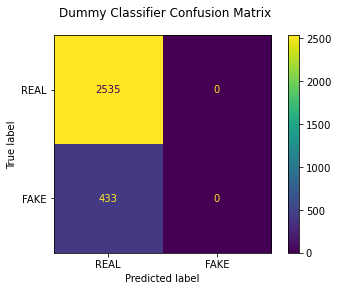

In [238]:
# Plot Confusion Matrix using the Train Set Data for DummyClassifier.
class_names = ['REAL', 'FAKE']
dummy_cm = plot_confusion_matrix(gs_3.best_estimator_.named_steps['dummy'], 
                                 gs_3_x_train_tfidf, y_im_train, display_labels=class_names)
plt.suptitle("Dummy Classifier Confusion Matrix")
plt.savefig('./images/Dummy_cf.png');

In [88]:
dummy_report = classification_report(y_im_train, dummy_pred, target_names = ['0', '1'])
print(dummy_report)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2535
           1       0.00      0.00      0.00       433

    accuracy                           0.85      2968
   macro avg       0.43      0.50      0.46      2968
weighted avg       0.73      0.85      0.79      2968



<b>Since Dummy Score has Accuracy-Score of 0.854, our model should draw Accuracy Score at least better than 0.854.

## 3.3 Decision Tree Model after Data Split

In [93]:
# Build a pipeline with TFIDF, SMOTE and Decision Tree Classifer, SMOTE was added to rebalance Training Data.
tree_pipeline_2 = Pipeline([('vect',TfidfVectorizer()),
                            ('smote', SMOTE()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid_4 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search
gs_4_t = GridSearchCV(estimator=tree_pipeline_2, 
                          param_grid=grid_4, 
                          scoring='f1_micro', 
                          cv=5)
gs_4_l = GridSearchCV(estimator=tree_pipeline_2, 
                          param_grid=grid_4, 
                          scoring='f1_micro', 
                          cv=5)
gs_4_s = GridSearchCV(estimator=tree_pipeline_2, 
                          param_grid=grid_4, 
                          scoring='f1_micro', 
                          cv=5)

In [94]:
# Build a pipeline with TFIDF, SMOTE and CountVectorizer, SMOTE was added to rebalance Training Data.
tree_pipeline_3 = Pipeline([('vect',CountVectorizer()),
                            ('smote', SMOTE()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid_5 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search
gs_5_t = GridSearchCV(estimator=tree_pipeline_3, 
                          param_grid=grid_5, 
                          scoring='f1_micro', 
                          cv=5)
gs_5_l = GridSearchCV(estimator=tree_pipeline_3, 
                          param_grid=grid_5, 
                          scoring='f1_micro', 
                          cv=5)
gs_5_s = GridSearchCV(estimator=tree_pipeline_3, 
                          param_grid=grid_5, 
                          scoring='f1_micro', 
                          cv=5)

### 3.3.1 TFIDF Vectorizer Cross Validation Results

In [97]:
# Using Lemmatized Text Dataset
gs_4_l.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_4_l.best_score_)

Best F1_Score: 0.870


In [98]:
# Using Stemmed Text Dataset
gs_4_s.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_4_s.best_score_)

Best F1_Score: 0.852


In [99]:
# Using Original Text Dataset
gs_4_t.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_4_t.best_score_)

Best F1_Score: 0.863


### 3.3.2 CountVectorizer Cross Validation Results

In [100]:
# Using Original Text Dataset
gs_5_t.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_5_t.best_score_)

Best F1_Score: 0.846


In [101]:
# Using Lemmatized Text Dataset
gs_5_l.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_5_l.best_score_)

Best F1_Score: 0.826


In [102]:
# Using Stemmed Text Dataset
gs_5_s.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_5_s.best_score_)

Best F1_Score: 0.838


TFIDF Vectorization using the Lemmatized Dataset shows the highest F1 Score at 0.870.

### 3.3.3 Decision Tree Model Evaluation With the Train Set

In [105]:
# Predicting the model for tf-idf features
tree_tf_imb_pred = gs_4_l.predict(x_im_lem_train)

In [106]:
# Check the accuracy score for tfidf features
Tree_tfimb_score=accuracy_score(y_im_lem_train, tree_tf_imb_pred)
print("Decision Tree TF-IDF accuracy score:", Tree_tfimb_score)

Decision Tree TF-IDF accuracy score: 0.9686657681940701


In [108]:
# Set x_train_tfidf value for Confusion Matrix Evaluation
gs4_x_train_tfimb = gs_4_l.best_estimator_.named_steps['vect'].transform(x_im_lem_train)

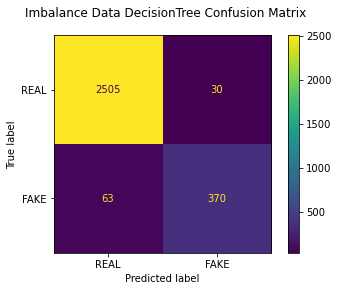

In [237]:
class_names = ['REAL', 'FAKE']
Tree_imb_cm = plot_confusion_matrix(gs_4_l.best_estimator_.named_steps['tree'], gs4_x_train_tfimb,
                                    y_im_lem_train, display_labels=class_names)
plt.suptitle("Imbalance Data DecisionTree Confusion Matrix")
plt.savefig('./images/Imb_Tree_cf.png');

In [111]:
Tree_tfimb_report = classification_report(y_im_lem_train, tree_tf_imb_pred, target_names = ['0','1'])
print(Tree_tfimb_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2535
           1       0.93      0.85      0.89       433

    accuracy                           0.97      2968
   macro avg       0.95      0.92      0.94      2968
weighted avg       0.97      0.97      0.97      2968



Accuracy Score is better than DummyClassifier at 0.0.969 which is <b>0.125</b> higher than DummyClassifer.<br>
The result looks quite satisfying, but let's try other models with different classifiers as well.

## 3.4 RandomForest Model after Data Split


In [112]:
# Build a pipeline with TFIDF and RandomForestClassifier
rdf_pipeline = Pipeline([('vect',TfidfVectorizer()),
                         ('smote', SMOTE()),
                 ('rdf',RandomForestClassifier())])

# Define the grid
grid_6 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'rdf__n_estimators': [10, 20, 30, 40]}]

# Define a grid search
gs_6_t = GridSearchCV(estimator=rdf_pipeline, 
                          param_grid=grid_6, 
                          scoring='f1_micro', 
                          cv=5)
gs_6_l = GridSearchCV(estimator=rdf_pipeline, 
                          param_grid=grid_6, 
                          scoring='f1_micro', 
                          cv=5)
gs_6_s = GridSearchCV(estimator=rdf_pipeline, 
                          param_grid=grid_6, 
                          scoring='f1_micro', 
                          cv=5)

In [113]:
# Build a pipeline with CountVectorizer and RandomForestClassifier
rdf_pipeline2 = Pipeline([('vect',CountVectorizer()),
                          ('smote', SMOTE()),
                 ('rdf',RandomForestClassifier())])

# Define the grid
grid_7 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'rdf__n_estimators': [10, 20, 30, 40]}]

# Define a grid search
gs_7_t = GridSearchCV(estimator=rdf_pipeline2, 
                          param_grid=grid_7, 
                          scoring='f1_micro', 
                          cv=5)
gs_7_l = GridSearchCV(estimator=rdf_pipeline2, 
                          param_grid=grid_7, 
                          scoring='f1_micro', 
                          cv=5)
gs_7_s = GridSearchCV(estimator=rdf_pipeline2, 
                          param_grid=grid_7, 
                          scoring='f1_micro', 
                          cv=5)

### 3.4.1 TFIDF Vectorizer Cross Validation Results

In [115]:
# Using Lemmatized Text Dataset
gs_6_l.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_6_l.best_score_)

Best F1_Score: 0.899


In [116]:
# Using Stemmed Text Dataset
gs_6_s.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_6_s.best_score_)

Best F1_Score: 0.888


In [117]:
# Using Original Text Dataset
gs_6_t.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_6_t.best_score_)

Best F1_Score: 0.899


### 3.4.2 CountVectorizer Cross Validation Results

In [118]:
# Using Original Text Dataset
gs_7_t.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_7_t.best_score_)

Best F1_Score: 0.877


In [119]:
# Using Lemmatized Text Dataset
gs_7_l.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_7_l.best_score_)

Best F1_Score: 0.885


In [120]:
# Using Stemmed Text Dataset
gs_7_s.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_7_s.best_score_)

Best F1_Score: 0.876


TFIDF Vectorizer with the lemmatized & original text have the same F1 Score, but I will select lemmatized text as the best model for the RandomForest Classifier as the trend shows better result with lemmatized text.

### 3.4.3 RandomForest Model Evaluation with the TrainSet

In [122]:
# Predicting the model for tf-idf features
dec_imb_pred = gs_6_l.predict(x_im_lem_train)

In [123]:
# Check the accuracy score for tfidf features
dec_imb_score=accuracy_score(y_im_lem_train, dec_imb_pred)
print("RandomForest TF-IDF accuracy score:", dec_imb_score)

RandomForest TF-IDF accuracy score: 1.0


In [124]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs6_rf_tfidf = gs_6_l.best_estimator_.named_steps['vect'].transform(x_im_lem_train)

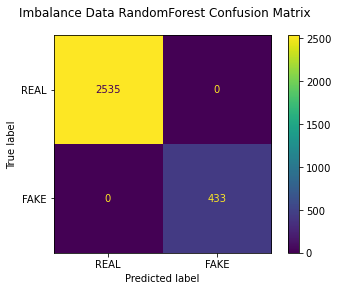

In [236]:
class_names = ['REAL', 'FAKE']
rfb_cm = plot_confusion_matrix(gs_6_l.best_estimator_.named_steps['rdf'], gs6_rf_tfidf,
                               y_im_lem_train, display_labels=class_names)
plt.suptitle("Imbalance Data RandomForest Confusion Matrix")
plt.savefig('./images/Imb_RF_cf.png');

In [126]:
rfb_report = classification_report(y_im_lem_train, dec_imb_pred, target_names = ['0','1'])
print(rfb_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2535
           1       1.00      1.00      1.00       433

    accuracy                           1.00      2968
   macro avg       1.00      1.00      1.00      2968
weighted avg       1.00      1.00      1.00      2968



RandomForest Classifier shows the perfect result for evaluation with the train set. However, there's high possibility of being overfit.

## 3.5 MultinomialNB Model after Data Split

In [127]:
# Build a pipeline with TFIDF and MultinomialClassifier
mlb_pipeline = Pipeline([('vect',TfidfVectorizer()),
                         ('smote', SMOTE()),
                 ('mlb',MultinomialNB())])

# Define the grid
grid_8 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],}]

# Define a grid search
gs_8_t = GridSearchCV(estimator=mlb_pipeline, 
                          param_grid=grid_8, 
                          scoring='f1_micro', 
                          cv=5)
gs_8_l = GridSearchCV(estimator=mlb_pipeline, 
                          param_grid=grid_8, 
                          scoring='f1_micro', 
                          cv=5)
gs_8_s = GridSearchCV(estimator=mlb_pipeline, 
                          param_grid=grid_8, 
                          scoring='f1_micro', 
                          cv=5)

In [128]:
# Build a pipeline with CountVectorizer and MultinomialClassifier
mlb_pipeline2 = Pipeline([('vect',CountVectorizer()),
                         ('smote', SMOTE()),
                 ('mlb',MultinomialNB())])

# Define the grid
grid_9 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],}]

# Define a grid search
gs_9_t = GridSearchCV(estimator=mlb_pipeline2, 
                          param_grid=grid_9, 
                          scoring='f1_micro', 
                          cv=5)
gs_9_l = GridSearchCV(estimator=mlb_pipeline2, 
                          param_grid=grid_9, 
                          scoring='f1_micro', 
                          cv=5)
gs_9_s = GridSearchCV(estimator=mlb_pipeline2, 
                          param_grid=grid_9, 
                          scoring='f1_micro', 
                          cv=5)

### 3.5.1 TFIDF Vectorizer Cross Validation Results

In [129]:
# Using Lemmatized Text Dataset
gs_8_l.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_8_l.best_score_)

Best F1_Score: 0.936


In [130]:
# Using Original Text Dataset
gs_8_t.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_8_t.best_score_)

Best F1_Score: 0.927


In [131]:
# Using Stemmed Text Dataset
gs_8_s.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_8_s.best_score_)

Best F1_Score: 0.923


### 3.5.2 CountVectorizer Cross Validation Results

In [132]:
# Using Original Text Dataset
gs_9_t.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9_t.best_score_)

Best F1_Score: 0.920


In [133]:
# Using Lemmatized Text Dataset
gs_9_l.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9_l.best_score_)

Best F1_Score: 0.926


In [134]:
# Using Stemmed Text Dataset
gs_9_s.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9_s.best_score_)

Best F1_Score: 0.921


As previsouly, Lemmatized Dataset with TFIDIF vecotrization shows the highest F1 Score as well for the Multinomial model. Also, F1 score is significantly higher than all the other classifiers we've used so far.

### 3.5.3 MultiNomial Model Evaluation with Train Set

Stemmed TFIDF Vectorizor is the best model according to CV.

In [136]:
# Predicting the model for tf-idf features
mlb_imb_pred = gs_8_l.predict(x_im_lem_train)

In [140]:
# Check the accuracy score for tfidf features
mlb_imb_score=accuracy_score(y_im_lem_train, mlb_imb_pred)
print("RandomForest TF-IDF accuracy score:", mlb_imb_score)

RandomForest TF-IDF accuracy score: 0.9780997304582211


In [142]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs8_mlb_tfidf = gs_8_l.best_estimator_.named_steps['vect'].transform(x_im_lem_train)

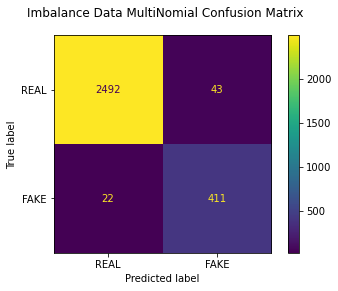

In [235]:
class_names = ['REAL', 'FAKE']
mlb_cm = plot_confusion_matrix(gs_8_l.best_estimator_.named_steps['mlb'], gs8_mlb_tfidf,
                               y_im_lem_train, display_labels=class_names)
plt.suptitle("Imbalance Data MultiNomial Confusion Matrix")
plt.savefig('./images/Imb_MNB_CF.png');

In [145]:
mlb_report = classification_report(y_im_lem_train, mlb_imb_pred, target_names = ['0','1'])
print(mlb_report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2535
           1       0.91      0.95      0.93       433

    accuracy                           0.98      2968
   macro avg       0.95      0.97      0.96      2968
weighted avg       0.98      0.98      0.98      2968



Multinomial Clasifier model definitely shows outstanding result compares to other models, and it is less likely to overfit than the previous RandomClassifier model.

## 3.6 PassiveAggressiveClassifier Model after Data Split

In [146]:
# Build a pipeline with TFIDF and MultinomialClassifier
pac_pipeline = Pipeline([('vect',TfidfVectorizer()),
                         ('smote', SMOTE()),
                 ('pac',PassiveAggressiveClassifier())])

# Define the grid
grid_10 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'pac__max_iter': [50, 200, 500, 1000]}]

# Define a grid search
gs_10_t = GridSearchCV(estimator=pac_pipeline, 
                          param_grid=grid_10, 
                          scoring='f1_micro', 
                          cv=5)
gs_10_l = GridSearchCV(estimator=pac_pipeline, 
                          param_grid=grid_10, 
                          scoring='f1_micro', 
                          cv=5)
gs_10_s = GridSearchCV(estimator=pac_pipeline, 
                          param_grid=grid_10, 
                          scoring='f1_micro', 
                          cv=5)

In [147]:
# Build a pipeline with TFIDF and MultinomialClassifier
pac_pipeline2 = Pipeline([('vect',CountVectorizer()),
                         ('smote', SMOTE()),
                 ('pac',PassiveAggressiveClassifier())])

# Define the grid
grid_11 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'pac__max_iter': [50, 200, 500, 1000]}]

# Define a grid search
gs_11_t = GridSearchCV(estimator=pac_pipeline2, 
                          param_grid=grid_11, 
                          scoring='f1_micro', 
                          cv=5)
gs_11_l = GridSearchCV(estimator=pac_pipeline2, 
                          param_grid=grid_11, 
                          scoring='f1_micro', 
                          cv=5)
gs_11_s = GridSearchCV(estimator=pac_pipeline2, 
                          param_grid=grid_11, 
                          scoring='f1_micro', 
                          cv=5)

### 3.6.1 TFIDF Vectorizer Cross Validation Results

In [148]:
# Using Original Text Dataset
gs_10_t.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_10_t.best_score_)

Best F1_Score: 0.939


In [149]:
# Using Stemmed Text Dataset
gs_10_s.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_10_s.best_score_)

Best F1_Score: 0.932


In [150]:
# Using Lemmatized Text Dataset
gs_10_l.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_10_l.best_score_)

Best F1_Score: 0.937


### 3.6.2 CountVectorizer Cross Validation Results

In [151]:
# Using Original Text Dataset
gs_9_t.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9_t.best_score_)

Best F1_Score: 0.921


In [152]:
# Using Lemmatized Text Dataset
gs_9_l.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9_l.best_score_)

Best F1_Score: 0.928


In [153]:
# Using Stemmed Text Dataset
gs_9_s.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9_s.best_score_)

Best F1_Score: 0.921


Unlike Previous classifiers, PassiveAggressive Classifier shows the highest F1 Score with the original dataset instead of lemmatized dataset. However,the score difference is pretty much negligible and to follow the trend, we will keep the lmmatized text as our final model parameter.

### 3.6.3 PassiveAggressiveClassifer Model Evaluation

Lemmatized TFIDF Vectorizor is the best model according to CV.

In [155]:
# Predicting the model for tf-idf features
pac_imb_pred = gs_10_l.predict(x_im_lem_train)

In [156]:
# Check the accuracy score for tfidf features
pac_imb_score=accuracy_score(y_im_lem_train, pac_imb_pred)
print("RandomForest TF-IDF accuracy score:", pac_imb_score)

RandomForest TF-IDF accuracy score: 1.0


In [157]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs10_pac_tfidf = gs_10_l.best_estimator_.named_steps['vect'].transform(x_im_lem_train)

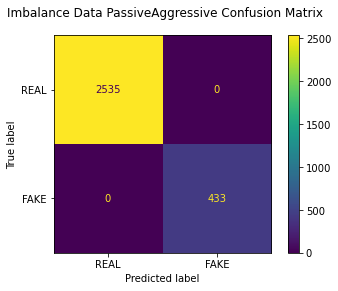

In [234]:
class_names = ['REAL', 'FAKE']
pac_cm = plot_confusion_matrix(gs_10_l.best_estimator_.named_steps['pac'], gs10_pac_tfidf, 
                               y_im_lem_train, display_labels=class_names)
plt.suptitle("Imbalance Data PassiveAggressive Confusion Matrix")
plt.savefig('./images/Imb_Pac_CF.png');

In [160]:
pac_report = classification_report(y_im_lem_train, pac_imb_pred, target_names = ['0','1'])
print(pac_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2535
           1       1.00      1.00      1.00       433

    accuracy                           1.00      2968
   macro avg       1.00      1.00      1.00      2968
weighted avg       1.00      1.00      1.00      2968



PassiveAgressive Model is showing highest Cross Validation F1 Score and the perfect confusion matrix evaluation score on the train set. We will select this model as our final model candidate.

***

# 4. Final Model

Based on the previous results, it is evident that PassiveAggressive & MultinomialNB classifiers are the best candidates for the final models as they showed landslide victory in CV F-1 score compared to all the other models. <br><br>
It is not a surprise that these two classifiers had the highest perofrmance as these two classifieres are specialized in classifying word count & text.

<b>Best Classifier = PassiveAggressive Classifier with TFIDFVecotrization using the lemmatized text.

## 4.1 Try Final model with undersampling

In [203]:
# Build a pipeline with TFIDF and PassiveAggressive Classifier.
pac_pipeline = Pipeline([('vect',TfidfVectorizer()),
                 ('pac',PassiveAggressiveClassifier())])

# Define the grid. More Hyperparameters were introduced to see the optimized model.
grid_10_l2 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'pac__max_iter': [50, 200, 500, 1000],
         'pac__tol': [.0001, .001, .005, .01],
         'pac__class_weight': ['balanced', 'none'],
         'pac__validation_fraction': [0.1, 0.2, 0.3, 0.4]}]

# Define a grid search
gs_10_l2 = GridSearchCV(estimator=pac_pipeline, 
                          param_grid=grid_10_l2, 
                          scoring='f1_micro', 
                          cv=5)

In [204]:
# Using Lemmatized Text Dataset
gs_10_l2.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_10_l2.best_score_)

Best F1_Score: 0.943


In [205]:
# Predicting the model for tf-idf features
pac_imb_predl2 = gs_10_l2.predict(x_im_lem_train)

In [206]:
# Check the accuracy score for tfidf features
pac_imb_score=accuracy_score(y_im_lem_train, pac_imb_predl2)
print("PassiveAggressive TF-IDF accuracy score:", pac_imb_score)

PassiveAggressive TF-IDF accuracy score: 1.0


In [207]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs10_pac_tfidfl2 = gs_10_l.best_estimator_.named_steps['vect'].transform(x_im_lem_train)

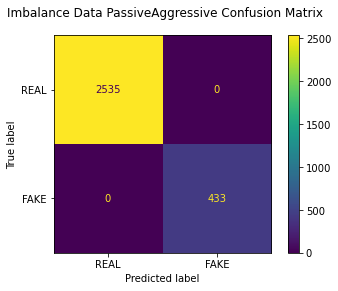

In [231]:
class_names = ['REAL', 'FAKE']
pac_cm = plot_confusion_matrix(gs_10_l.best_estimator_.named_steps['pac'], gs10_pac_tfidfl2,
                               y_im_lem_train, display_labels=class_names)
plt.suptitle("Imbalance Data PassiveAggressive Confusion Matrix")
plt.savefig('./images/Imb_Pac_CF_undersample.png');

In [209]:
pac_report = classification_report(y_im_lem_train, pac_imb_pred, target_names = ['0','1'])
print(pac_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2535
           1       1.00      1.00      1.00       433

    accuracy                           1.00      2968
   macro avg       1.00      1.00      1.00      2968
weighted avg       1.00      1.00      1.00      2968



## 4.2 Model Testing with the Final Model

In [210]:
# Predicting the model for tf-idf features
pac_imb_pred_final = gs_10_l2.predict(x_im_lem_test)

In [211]:
# Check the accuracy score for tfidf features
pac_imb_final_score=accuracy_score(y_im_lem_test, pac_imb_pred_final)
print("PassiveAggressive TF-IDF accuracy score:", pac_imb_final_score)

PassiveAggressive TF-IDF accuracy score: 0.9245283018867925


In [212]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs10_pac_tfidf_final = gs_10_l2.best_estimator_.named_steps['vect'].transform(x_im_lem_test)

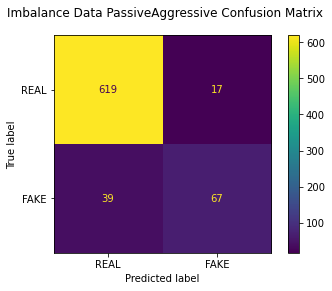

In [230]:
class_names = ['REAL', 'FAKE']
pac_cm = plot_confusion_matrix(gs_10_l2.best_estimator_.named_steps['pac'], gs10_pac_tfidf_final , 
                               y_im_lem_test, display_labels=class_names)
plt.suptitle("Imbalance Data PassiveAggressive Confusion Matrix")
plt.savefig('./images/Imb_Pac_CF_final.png');

In [214]:
pac_final_report = classification_report(y_im_lem_test, pac_imb_pred_final, target_names = ['0','1'])
print(pac_final_report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       636
           1       0.80      0.63      0.71       106

    accuracy                           0.92       742
   macro avg       0.87      0.80      0.83       742
weighted avg       0.92      0.92      0.92       742



In [215]:
## shows parameters used in the FINAL Model.
gs_10_l2.best_estimator_

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.7, min_df=0, stop_words='english')),
                ('pac',
                 PassiveAggressiveClassifier(class_weight='balanced', tol=0.01,
                                             validation_fraction=0.2))])

Final model when evaluated with the Test Set, F1 Score dropped quite significantly. However, Precision score remained at 0.80 which I think is quite satisfying. Our model worked to mimnimize false negative rates. To dissect best prameters:
1. TFidfvecgtorizer was used. Stop Words used = 'english' (Definitely showed better performance than CountVectorizer in almost all cases)
2. Training Class: 0.17 : 1.00 FAKE to REAL News Ratio was used.
3. Lemmatized Text was used for training and evaluation which showed better CV result in most of the models.
4. PassiveAggressive Classifier was used.

# 5. Conclusion

From the Cross Validation F-1 Score, PassiveAggressive classification model is chosen to be the best perfomring model. For the Final Model, following parameters were chosen to build up the best model:
1. TfIDF Vectorizer was used with stop_words in'english'. (Max_df=0.7)
2. PassiveAggressive Classification model was used.
3. Lemmatized Text was used for training and evaluation.
4. For the training, class balance was maintained at 0.17:1.0 class ratio.


For the final model testing with the Test Set:
1. Precision (True Positive Rate) = 0.80
2. Recall (Proportion of FAKE news classified correctly)  = 0.63
3. F-1 Score = 0.71

***

# 6. Ideas for Improvement

1. Try Unsupervised Learning Models. (Deep Learning)
2. Try Web-Scraping from Fake News sites like Onions and see how well our model performs.
3. Try Web-Scraping from Social Media and see the Fake News Detection Rate.
